In [1]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data_path = (r"C:\Users\killa\archive (2)\Training")

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [3]:
train_df

,filepaths,label
0,C:\Users\killa\archive (2)\Training\glioma\Tr-...,glioma
1,C:\Users\killa\archive (2)\Training\glioma\Tr-...,glioma
2,C:\Users\killa\archive (2)\Training\glioma\Tr-...,glioma
3,C:\Users\killa\archive (2)\Training\glioma\Tr-...,glioma
4,C:\Users\killa\archive (2)\Training\glioma\Tr-...,glioma
...,...,...
5707,C:\Users\killa\archive (2)\Training\pituitary\...,pituitary
5708,C:\Users\killa\archive (2)\Training\pituitary\...,pituitary
5709,C:\Users\killa\archive (2)\Training\pituitary\...,pituitary
5710,C:\Users\killa\archive (2)\Training\pituitary\...,pituitary


In [23]:
test_data_path = (r"C:\Users\killa\archive (2)\Training")

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [24]:
test_df

,filepaths,label
0,C:\Users\killa\archive (2)\Training\glioma\Tr-...,glioma
1,C:\Users\killa\archive (2)\Training\glioma\Tr-...,glioma
2,C:\Users\killa\archive (2)\Training\glioma\Tr-...,glioma
3,C:\Users\killa\archive (2)\Training\glioma\Tr-...,glioma
4,C:\Users\killa\archive (2)\Training\glioma\Tr-...,glioma
...,...,...
5707,C:\Users\killa\archive (2)\Training\pituitary\...,pituitary
5708,C:\Users\killa\archive (2)\Training\pituitary\...,pituitary
5709,C:\Users\killa\archive (2)\Training\pituitary\...,pituitary
5710,C:\Users\killa\archive (2)\Training\pituitary\...,pituitary


In [25]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

In [26]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.
Found 2856 validated image filenames belonging to 4 classes.


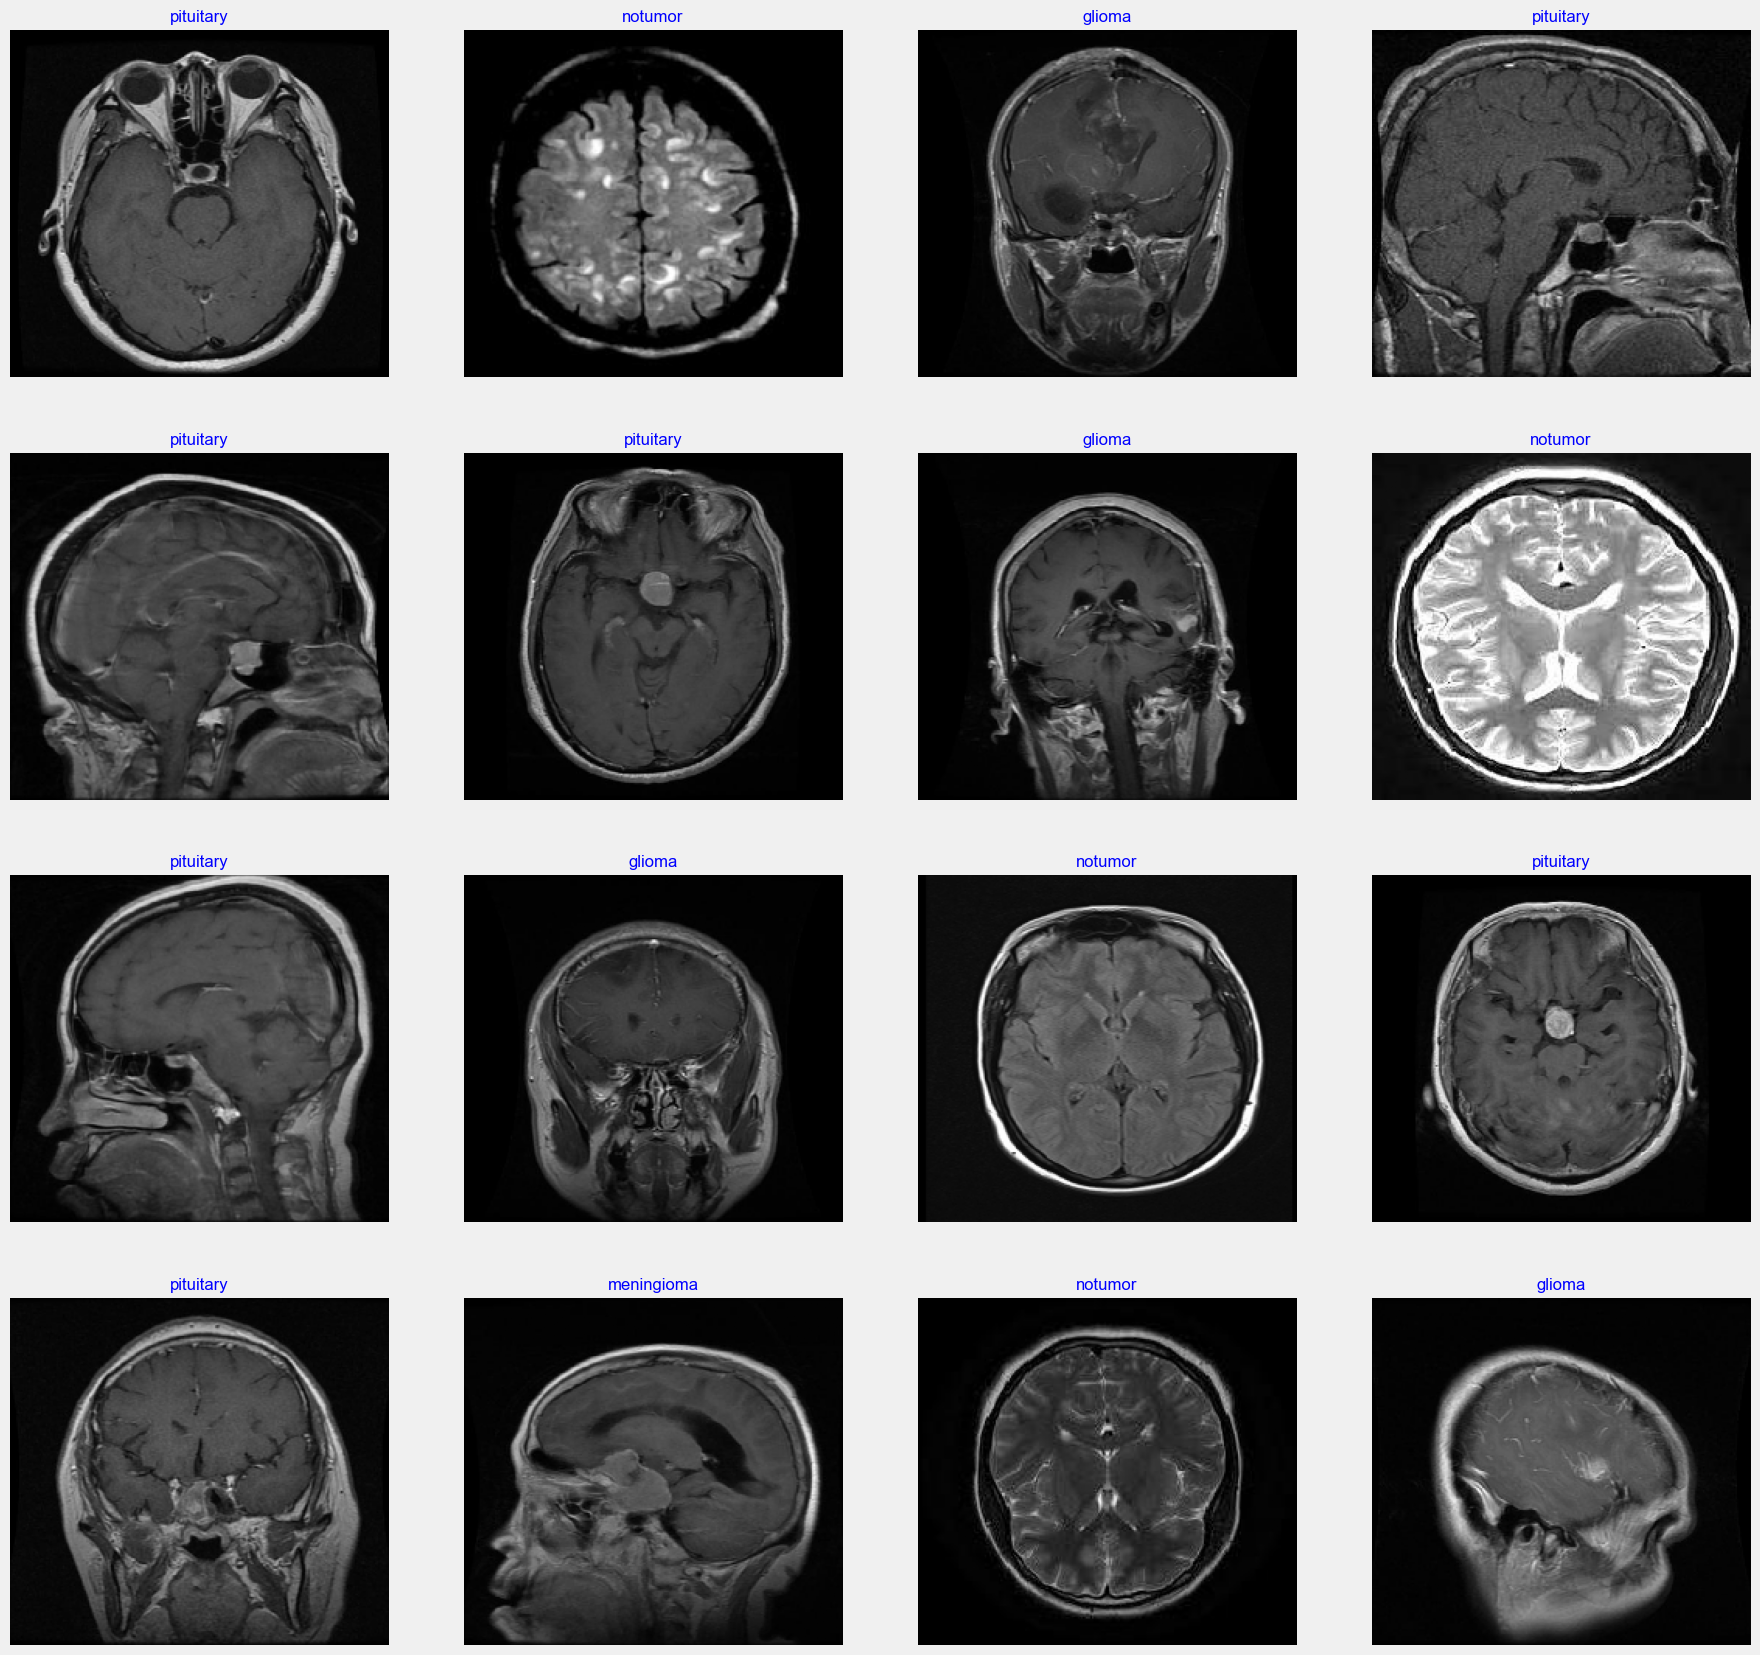

In [27]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

In [28]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model =  MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [29]:
Epochs = 10

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)  

Epoch 1/10
357/357 [==============================] - 308s 856ms/step - loss: 0.5323 - accuracy: 0.8081 - val_loss: 0.3527 - val_accuracy: 0.8813
Epoch 2/10
357/357 [==============================] - 367s 1s/step - loss: 0.3406 - accuracy: 0.8768 - val_loss: 0.2814 - val_accuracy: 0.9069
Epoch 3/10
357/357 [==============================] - 431s 1s/step - loss: 0.2897 - accuracy: 0.8983 - val_loss: 0.2572 - val_accuracy: 0.9083
Epoch 4/10
357/357 [==============================] - 439s 1s/step - loss: 0.2575 - accuracy: 0.9140 - val_loss: 0.2337 - val_accuracy: 0.9181
Epoch 5/10
357/357 [==============================] - 437s 1s/step - loss: 0.2356 - accuracy: 0.9182 - val_loss: 0.2092 - val_accuracy: 0.9279
Epoch 6/10
357/357 [==============================] - 430s 1s/step - loss: 0.2170 - accuracy: 0.9224 - val_loss: 0.2095 - val_accuracy: 0.9237
Epoch 7/10
357/357 [==============================] - 422s 1s/step - loss: 0.2066 - accuracy: 0.9244 - val_loss: 0.1866 - val_accuracy: 0.9

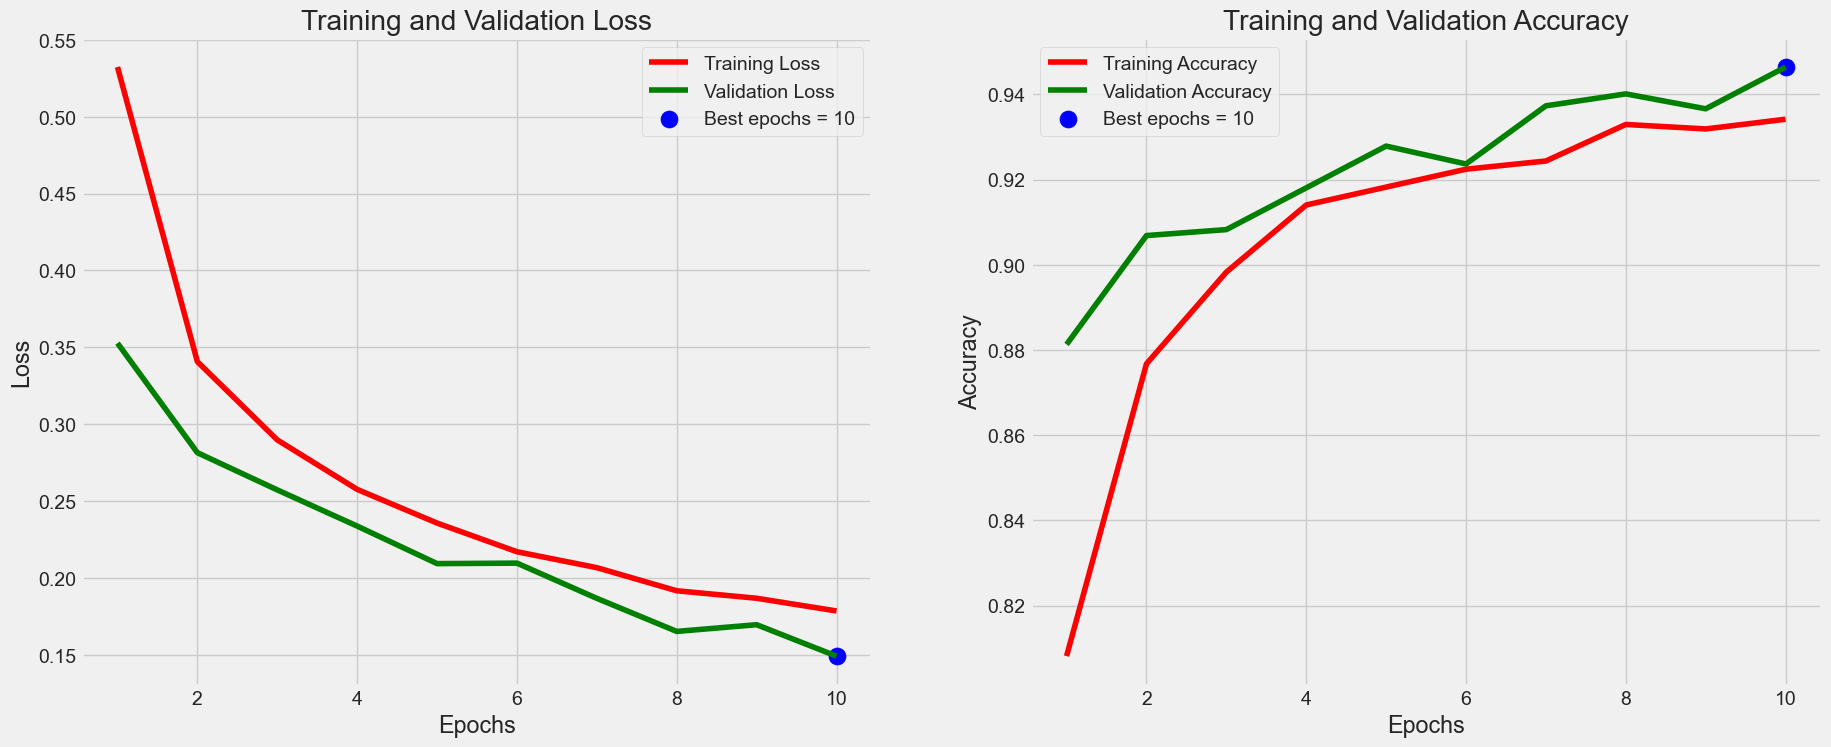

In [30]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [31]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 12s 736ms/step - loss: 0.1502 - accuracy: 0.9492
Train Loss:  0.15387152135372162
Train Accuracy:  0.93359375
--------------------
Validation Loss:  0.16066469252109528
Validation Accuracy:  0.94140625
--------------------
Test Loss:  0.1502426415681839
Test Accuracy:  0.94921875


In [32]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

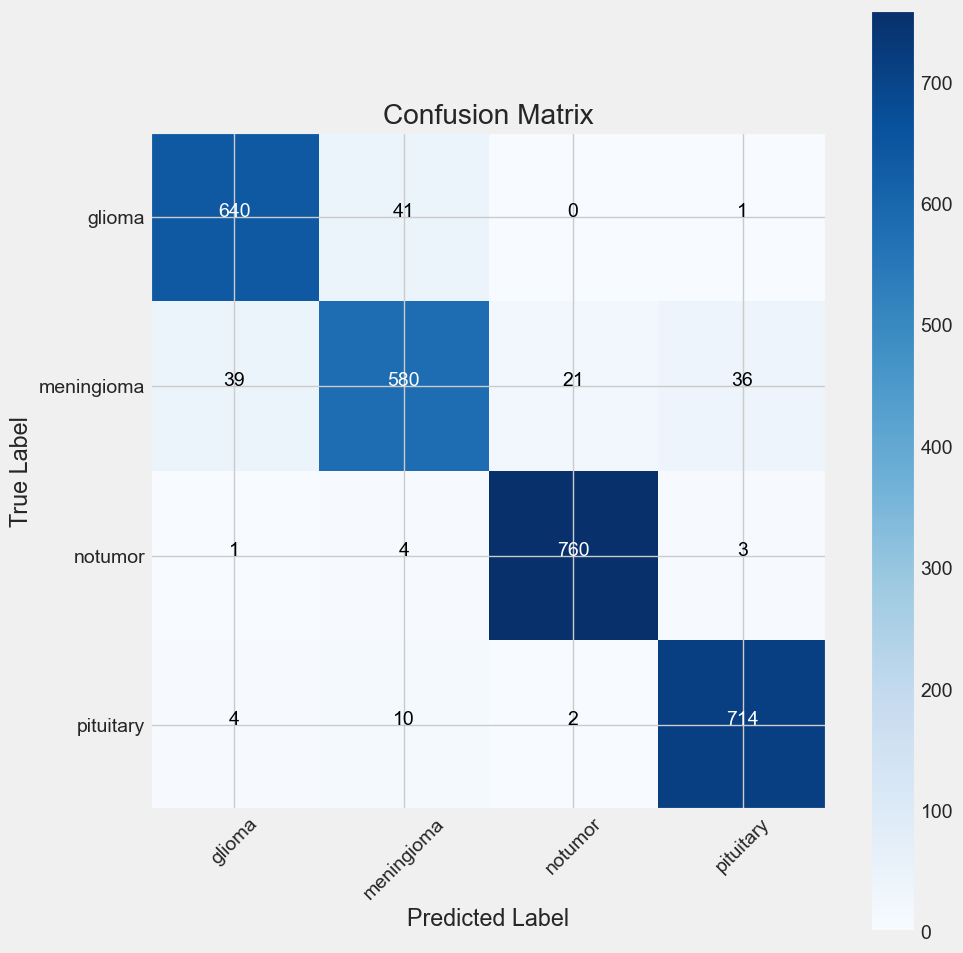

In [33]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [34]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.94      0.94      0.94       682
  meningioma       0.91      0.86      0.88       676
     notumor       0.97      0.99      0.98       768
   pituitary       0.95      0.98      0.96       730

    accuracy                           0.94      2856
   macro avg       0.94      0.94      0.94      2856
weighted avg       0.94      0.94      0.94      2856



In [35]:
#Save the model
model.save('Brain Tumors.h5')

In [36]:
loaded_model = tf.keras.models.load_model(r"C:\Users\killa\Brain Tumors.h5", compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

1/1 [==============================] - 2s 2s/step
Glioma


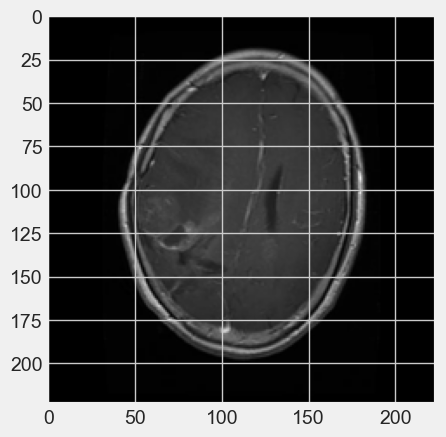

In [37]:
image_path = (r"C:\Users\killa\archive (2)\Testing\glioma\Te-gl_0035.jpg")
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")
plt.imshow(img)

In [38]:
from twilio.rest import Client

# Twilio Account SID and Auth Token
account_sid = 'ACa76b6f04916f20d9b191b71712def1ef'
auth_token = '2ed7a10c964ec971b07eff5838fddb14'

# Initialize Twilio client
client = Client(account_sid, auth_token)

# Your Twilio phone number (you must own this number)
twilio_phone_number = '+17855092214'

# Recipient phone number (your own phone number or any other recipient)
recipient_phone_number = '+919392772106'

# Message to send
message = "Dear [Recipient's Name],We regret to inform you that the medical imaging results indicate the presence of a tumor. It is crucial that you take immediate action to address this issue. Early diagnosis and treatment can significantly improve the outcome. Type of tumor:{class_labels[tf.argmax(score)]}"

# Send the SMS
message = client.messages.create(
    body=message,
    from_=twilio_phone_number,
    to=recipient_phone_number
)

# Print the message SID as confirmation
print(f"Message SID: {message.sid}")

Message SID: SMa1bdc5be40333434ceed98c9524c2274


In [41]:
!pip3 install twilio

                                              0.0/1.8 MB ? eta -:--:--
                                              0.0/1.8 MB 653.6 kB/s eta 0:00:03
     --                                       0.1/1.8 MB 1.2 MB/s eta 0:00:02
     ------                                   0.3/1.8 MB 2.1 MB/s eta 0:00:01
     -----------                              0.5/1.8 MB 2.6 MB/s eta 0:00:01
     -------------                            0.6/1.8 MB 3.0 MB/s eta 0:00:01
     ----------------                         0.7/1.8 MB 2.5 MB/s eta 0:00:01
     ----------------------                   1.0/1.8 MB 2.8 MB/s eta 0:00:01
     -----------------------------            1.3/1.8 MB 3.2 MB/s eta 0:00:01
     -------------------------------------    1.6/1.8 MB 3.7 MB/s eta 0:00:01
     ---------------------------------------- 1.8/1.8 MB 3.6 MB/s eta 0:00:00
                                              0.0/320.6 kB ? eta -:--:--
     --------------------------------       276.5/320.6 kB 8.6 MB/s eta 0: